### Using a Variational Auto-encoder to predict protein fitness from evolutionary data

July 20, 2017
### Sam Sinai and Eric Kelsic


## For the blog post associated with this notebook see [this post](https://samsinai.github.io/jekyll/update/2017/08/14/Using-a-Variational-Autoencoder-to-predict-protein-function.html). 


This notebook it organized in 3 sections. In section 1 we show our workflow for pre-processing the biological data. We then train the model on the alignment data in section 2. In section 3 we compare the predictions of the model on the [PABP yeast](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851721/) dataset. In section 4 we report the results from analyzing multiple other datasets. Finally we pose some questions with regards to improving the model for interested researcher.

In [1]:
### IT'S 82 x 24

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math,random,re
import time

In [4]:
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as D
# import tensorflow as tf
# import keras
# from keras.layers import Input, Dense
# from keras.models import Model
# from keras import regularizers
# from keras.layers import LSTM, RepeatVector
# from keras.layers import Input, Dense, Lambda, Dropout,Activation, TimeDistributed
# from keras import backend as K
# from keras import objectives
# from keras.callbacks import EarlyStopping
# from keras.layers.normalization import BatchNormalization
# from keras import regularizers

In [5]:
# JUST UPLOAD MANUALLY TBH

# # if in colab

# # models
# print('models.py')
# from google.colab import files
# src = list(files.upload().values())[0]
# open('models.py','wb').write(src)

# # helper_tools
# print('helper_tools.py')
# from google.colab import files
# src = list(files.upload().values())[0]
# open('helper_tools.py','wb').write(src)

# # helper_tools_for_plotting
# print('helper_tools_for_plotting.py')
# from google.colab import files
# src = list(files.upload().values())[0]
# open('helper_tools_for_plotting.py','wb').write(src)

# # singles
# print('PABP_YEAST_Fields2013-singles.csv')
# from google.colab import files
# src = list(files.upload().values())[0]
# open('PABP_YEAST_Fields2013-singles.csv','wb').write(src)

# # doubles
# print('PABP_YEAST_Fields2013-doubles.csv')
# from google.colab import files
# src = list(files.upload().values())[0]
# open('PABP_YEAST_Fields2013-doubles.csv','wb').write(src)

# # PABP_YEAST_hmmerbit_t0.2_r50000.reweight
# print('PABP_YEAST_hmmerbit_t0.2_r50000.reweight')
# from google.colab import files
# src = list(files.upload().values())[0]
# open('PABP_YEAST_hmmerbit_t0.2_r50000.reweight','wb').write(src)

# # PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m
# print('PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m')
# from google.colab import files
# src = list(files.upload().values())[0]
# open('PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m','wb').write(src)

In [6]:
from models import *

## 1.  Data pre-processing

Defining the alphabet that is used for Amino-Acids throughout.

In [7]:
#Invariants
ORDER_KEY="XILVAGMFYWEDQNHCRKSTPBZ-"[::-1]
ORDER_LIST=list(ORDER_KEY)

These are helper functions to clean and process data. 

In [8]:
%reload_ext autoreload
%autoreload 1
from helper_tools import *
from helper_tools_for_plotting import *

Import the alignment data:

In [9]:
data=pdataframe_from_alignment_file("PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m",50000)
print ("number of data points: ",len(data))
data_set_size=len(data)
data.head()

number of data points:  50000


,name,sequence
0,PABP_YEAST/115-210,qrdpslrkKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...
1,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/203-294,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKD...
2,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/534-625,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKD...
3,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/312-398,........IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVD...
4,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/33-112,........---ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRD...


Let's see how long the sequence is

In [10]:
print ("length of sequence:", len(data.iloc[0]["sequence"]))#, len(data.iloc[0]["seq"]))
print ("sample sequence: ", data.iloc[0]["sequence"])

length of sequence: 96
sample sequence:  qrdpslrkKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGFGFVHFEEEGAAKEAIDALNGMLLNGQEIYVAPHLSRkerdsq


We are only really interested in the columns that do align. This means that for every column that we include, at least 50% of sequences are not gaps. Note that this threshold is imposed by the alignment parameters loaded above. So let's make a column for that. Meanwhile, we keep track of the indices that did align.

In [11]:
indices=index_of_non_lower_case_dot(data.iloc[0]["sequence"])
data["seq"]=list(map(prune_seq,data["sequence"]))
data.head()

,name,sequence,seq
0,PABP_YEAST/115-210,qrdpslrkKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...,KGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGF...
1,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/203-294,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKD...,PKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKDENGNSRGF...
2,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/534-625,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKD...,PKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKDENGNSRGF...
3,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/312-398,........IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVD...,IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVDSQGQSKGS...
4,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/33-112,........---ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRD...,---ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRDIRRVSLGY...


Let's see how many columns remained. 

In [12]:
print ("pruned sequence length:", len(data.iloc[0]["seq"]))
PRUNED_SEQ_LENGTH=len(data.iloc[0]["seq"])

pruned sequence length: 82


A few optional lines of code to run. Printing indices, and deleting the sequence column so that it doesn't stay in memory for no reason. 

In [13]:
#print (indices,len(indices))
## you can do this to reduce memory load
#del data["sequence"]
#data.head()
#data.iloc[0]["sequence"][9]

Another useful preprocessing step is to reweight the sequences based on some similarity threshold. This helps us feed the network with more informative samples (namely discount sequences that are very close to each other). We weight all $n$ sequences that are more that 1-$\theta$ similar to each other as $1/n$. Computing this step is rather slow, so I've provided the sample weights for $\theta=0.2$, which is standard in the studies I reference. You can run the process for arbitrary $\theta$ using the commented out line.

In [14]:
with open ("PABP_YEAST_hmmerbit_t0.2_r50000.reweight","rb") as to_read:
    new_weights=np.load(to_read)

#new_weights=reweight_sequences(data["seq"],0.1)
len(new_weights),new_weights[:10]

(50000, array([0.03125   , 0.2       , 0.2       , 0.2       , 0.16666667,
        0.2       , 0.16666667, 0.16666667, 0.0625    , 1.        ]))

Next we translate the sequence into a one hot encoding and shape the input sequences into a m*n matrix. Here m is the number of the data points and $n=$ alphbet size $\times$ sequence length.

In [15]:
#Encode training data in one_hot vectors
training_data_one_hot=[]
labels=[]
for i, row in data.iterrows():
    training_data_one_hot.append(translate_string_to_one_hot(row["seq"],ORDER_LIST))
print (len(training_data_one_hot),len(training_data_one_hot[0]),len(training_data_one_hot[0][0]))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
training_data=np.array([np.array(list(sample.T.flatten())) for sample in training_data_one_hot])
# training_data=np.array([np.array(list(sample.flatten())).T for sample in training_data_one_hot])
print(training_data.shape)

50000 24 82
(50000, 1968)


In [16]:
### seq_len = 82, alphabet_size = 24

In [17]:
np.argmax(training_data_one_hot[0],axis=0)

array([ 6, 18,  5, 18, 10, 22, 16, 22,  6, 10, 21,  9,  3, 12, 22, 12, 10,
        6, 19, 21, 15, 12,  4, 16,  5, 20, 16, 18, 12, 22, 21,  5,  5,  6,
       22, 19,  4, 12, 13, 10, 18,  6,  5,  6, 18, 16, 18, 16, 20,  9, 16,
       13, 13, 13, 18, 19, 19,  6, 13, 19, 22, 12, 19, 21, 10, 18, 17, 21,
       21, 10, 18, 11, 13, 22, 15, 20, 19,  3,  9, 21,  5,  7])

That takes care of the training data. But we also need to test our model on something. Thankfully, some neat experiments have been done to actually measure the effects of change in a sequence on the performance of the protein. We load this data next (because we want to make use of this test data to evaluate our performance at the end of each epoch). 

In [18]:
exp_data_full=pd.read_csv(
    "PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
print ("number of mutants: ",len(exp_data_full))
exp_data_full.head()
exp_data_full.iloc[87]

number of mutants:  1188


mutant                               K131V
effect_prediction_epistatic         -10.06
effect_prediction_independent     -3.36052
linear                           0.0425856
Name: 87, dtype: object

The "linear" column is the experimental data. The other two predictions are the results as obtained by the method described in the [Hopf et al paper](https://www.nature.com/nbt/journal/v35/n2/abs/nbt.3769.html). 

In [19]:
exp_data_full.corr(method="spearman")

,effect_prediction_epistatic,effect_prediction_independent,linear
effect_prediction_epistatic,1.000000,0.745161,0.592781
effect_prediction_independent,0.745161,1.000000,0.423680
linear,0.592781,0.423680,1.000000


The experimentalists have made the mutations on specific positions on the sequence. We restrict our target data to the subset of those experiments that we have aligned columns for. 

In [20]:
OFFSET=117
#Deciding offset requires investigating the dataset and alignment.
exp_data_singles=pd.DataFrame(columns=exp_data_full.columns)
#decide starting index depending on how the file is "headered"
for i,row in exp_data_full[1:].iterrows():
        pos=re.split(r'(\d+)', row.mutant) 
        if int(pos[1])-OFFSET in indices:
            exp_data_singles=exp_data_singles.append(row)
exp_data_singles=exp_data_singles.reset_index()
target_values_singles=list(exp_data_singles["linear"])
exp_data_singles.head(10)        

,index,mutant,effect_prediction_epistatic,effect_prediction_independent,linear
0,1,G126C,-5.663638,-0.027602,0.449027
1,2,G126E,-6.611062,-1.827612,0.588928
2,3,G126D,-7.270577,-1.180094,0.229853
3,4,G126N,-5.809167,0.387443,0.679435
4,5,G126S,-4.617248,0.661686,0.721788
5,6,G126R,-5.582381,1.144148,0.313690
6,7,G126W,-8.079901,-2.052391,0.226032
7,8,G126V,-5.435631,-0.800307,0.230315
8,9,N127A,-4.987206,-2.251823,0.062650
9,10,N127C,-8.044181,-2.215639,0.024996


Using this data, we can now make a library of sequences of single mutants, in the same form of the alignment data.

In [21]:
mutation_data=[re.split(r'(\d+)', s) for s in exp_data_singles.mutant]
wt_sequence=data.iloc[0].seq
mutants=mutate_single(wt_sequence,mutation_data,offset=0,index=3) #note that you change index to 1

#sanity checks
print (len(mutants),len(exp_data_singles))
#the mutant should be in the correct place
print (list(zip(wt_sequence,mutants[3]))[:10])

1187 1187
[('K', 'K'), ('G', 'G'), ('S', 'S'), ('G', 'N'), ('N', 'N'), ('I', 'I'), ('F', 'F'), ('I', 'I'), ('K', 'K'), ('N', 'N')]


The last print above is a simple check to show that the mutation in the sequence is indeed an G to N (in the third mutant). We also make the one-hot vectors for this data.

In [22]:
#Test data with wt at 0 index
one_hot_mutants=[]
mutants_plus=[data.iloc[0]["seq"]]+mutants
for mutant in mutants_plus:
    one_hot_mutants.append(translate_string_to_one_hot("".join(mutant),ORDER_LIST))

test_data_plus=np.array([np.array(list(sample.flatten())).T for sample in one_hot_mutants])

We also construct the double mutant sequences using the same process

In [23]:
exp_data_full=pd.read_csv(
    "PABP_YEAST_Fields2013-doubles.csv", sep=";", comment="#"
)
print ("number of mutants: ",len(exp_data_full))
exp_data_full.head()
exp_data_full.iloc[0]

number of mutants:  36522


mutant                           G169W,F170V
effect_prediction_epistatic          -18.161
effect_prediction_independent       -15.1525
XY_Enrichment_score                  0.05916
Name: 0, dtype: object

In [24]:
exp_data_full.corr(method="spearman")

,effect_prediction_epistatic,effect_prediction_independent,XY_Enrichment_score
effect_prediction_epistatic,1.000000,0.715371,0.620022
effect_prediction_independent,0.715371,1.000000,0.497743
XY_Enrichment_score,0.620022,0.497743,1.000000


In [25]:
OFFSET=160
#Deciding offset requires investigating the dataset and alignment.
exp_data_doubles=pd.DataFrame(columns=exp_data_full.columns)
#decide starting index depending on how the file is "headered"
for i,row in exp_data_full[0:].iterrows():
        pos=re.split(r'(\d+)', row.mutant)
        if int(pos[1])-OFFSET in indices and int(pos[3])-OFFSET in indices:
            exp_data_doubles=exp_data_doubles.append(row)
exp_data_doubles=exp_data_doubles.reset_index()
exp_data_doubles.head(5)

,index,mutant,effect_prediction_epistatic,effect_prediction_independent,XY_Enrichment_score
0,0,"G169W,F170V",-18.161003,-15.152495,0.059160
1,1,"G169V,F170V",-13.753099,-8.845704,0.045765
2,2,"G169A,F170I",-9.115749,-3.954389,0.075799
3,3,"G169C,F170Y",-9.761077,-4.004533,0.700485
4,4,"G169A,F170S",-10.212144,-5.743002,0.061518


In [26]:
target_values_doubles=list(exp_data_doubles["XY_Enrichment_score"])
exp_data_doubles.corr(method="spearman")

,index,effect_prediction_epistatic,effect_prediction_independent,XY_Enrichment_score
index,1.000000,0.143941,0.140272,0.117997
effect_prediction_epistatic,0.143941,1.000000,0.773236,0.520277
effect_prediction_independent,0.140272,0.773236,1.000000,0.488397
XY_Enrichment_score,0.117997,0.520277,0.488397,1.000000


In [27]:
mutation_data1=[re.split(r'(\d+)', s.split(",")[0]) for s in exp_data_doubles.mutant]
mutation_data2=[re.split(r'(\d+)', s.split(",")[1]) for s in exp_data_doubles.mutant]
wt_sequence=data.iloc[0].seq

mutants_double=mutate_double(wt_sequence,mutation_data1,mutation_data2,offset=0,index=46)

#sanity checks
print (len(mutants_double),len(exp_data_doubles))
#the mutant should be in the correct place
print (list(zip(wt_sequence,mutants_double[2]))[40:50])

13876 13876
[('G', 'G'), ('K', 'K'), ('S', 'S'), ('K', 'K'), ('G', 'G'), ('F', 'F'), ('G', 'A'), ('F', 'I'), ('V', 'V'), ('H', 'H')]


Again, we can check that the second mutant is indeed a double G169A, F170I mutant.

In [28]:
#Test data with wt at 0 index
one_hot_mutants=[]
mutants_plus=[data.iloc[0]["seq"]]+mutants_double
for mutant in mutants_plus:
    one_hot_mutants.append(translate_string_to_one_hot("".join(mutant),ORDER_LIST))

test_data_doubles_plus=np.array([np.array(list(sample.flatten())).T for sample in one_hot_mutants])

We can combine the singles and doubles training data for convenience

In [29]:
all_test_data=np.vstack([test_data_plus,test_data_doubles_plus[1:]])
all_test_data_flattened=np.array([np.array(list(sample.flatten())).T for sample in all_test_data])

This concludes the pre-processing we need to do on the data.

## 2.  Training the model
We now move on to define our neural network. This is essentially a vanilla VAE in keras (with some optimization on hyperparameters). For optimization purposes we define a callback function that reports the predictive power of the model in the end of each epoch. Note that while this passes the -test data- through the model, it is kosher because we never pass in the values we are actually interested in and the network is not in "training phase", i.e. no weights are updated during this pass. 

In [30]:
class rho_vs_mutants():
    def __init__(self,mutants,test_set_size,aa_size,sequence_size):
        self.mutants=mutants
        self.sample_size=test_set_size
        self.aa_size=aa_size
        self.sequence_size=sequence_size
        self.scores=[]
        self.count_batch=0
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    #This allows us to track the "progress" of the model on different epochs
    def on_epoch_end(self,model,batch,logs):
        x_decoded=model(test_data_plus[0:self.sample_size],batch_size=batch_size)
        digit = x_decoded[0].reshape(self.aa_size,self.sequence_size)
        digit_wt = normalize(digit,axis=0, norm='l1')
        wt_prob=compute_log_probability(digit,digit_wt)
        fitnesses=[]
        for sample in range(1,self.sample_size):
            digit = x_decoded[sample].reshape(self.aa_size,self.sequence_size)
            digit = normalize(digit,axis=0, norm='l1')
            fitness=compute_log_probability(test_data_plus[sample].reshape(self.aa_size,self.sequence_size),digit)-wt_prob
            fitnesses.append(fitness)
        print (","+str(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])))
        self.scores.append(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])[0])

Now we are ready to specify the network architecture, this is adapted from [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py).

In [31]:
# torch.sum(1 + model.z_log_var - (model.z_mean)**2 - torch.exp(model.z_log_var),-1)

In [32]:
batch_size = 20
original_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
output_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
latent_dim = 24
intermediate_dim = 250
nb_epoch = 6
epsilon_std = 1.0
np.random.seed(42)
lang_mod = True
cuda = True

def create_tensor(x,gpu=False):
    if gpu:
        return x.cuda()
    return x

loss1 = nn.CrossEntropyLoss()

def vae_loss(x_true, x_decoded_mean, z_mean, z_log_var):
    xent_loss = original_dim * loss1(x_decoded_mean, x_true)
    kl_loss = -0.5 * torch.sum(1 + z_log_var - (z_mean)**2 - torch.exp(z_log_var))
    return (xent_loss + kl_loss), xent_loss, kl_loss

# #Encoding Layers
# x = Input(batch_shape=(batch_size, original_dim))
# h = Dense(intermediate_dim,activation="elu")(x)
# h= Dropout(0.7)(h)
# h = Dense(intermediate_dim, activation='elu')(h)
# h=BatchNormalization(mode=0)(h)
# h = Dense(intermediate_dim, activation='elu')(h)

# #Latent layers
# z_mean=Dense(latent_dim)(h)
# z_log_var=Dense(latent_dim)(h)
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# #Decoding layers 

# decoder_1= Dense(intermediate_dim, activation='elu')
# decoder_2=Dense(intermediate_dim, activation='elu')
# decoder_2d=Dropout(0.7)
# decoder_3=Dense(intermediate_dim, activation='elu')
# decoder_out=Dense(output_dim, activation='sigmoid')
# x_decoded_mean = decoder_out(decoder_3(decoder_2d(decoder_2(decoder_1(z)))))

# vae = Model(x, x_decoded_mean)

# #Potentially better results, but requires further hyperparameter tuning
# #optimizer=keras.optimizers.SGD(lr=0.005, momentum=0.001, decay=0.0, nesterov=False,clipvalue=0.05)
# vae.compile(optimizer="adam", loss=vae_loss,metrics=["categorical_accuracy","fmeasure","top_k_categorical_accuracy"])

And run it through our training data.

In [33]:
x_train=training_data[:data_set_size] #this needs to be divisible by batch size and less than or equal to dataset size
x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
spearman_measure=rho_vs_mutants(test_data_plus,batch_size*int(len(test_data_plus)/batch_size),len(ORDER_LIST),PRUNED_SEQ_LENGTH)

In [34]:
vae_type = 'rec'

In [35]:
def conv_size_func(Lin,dilation,kernel,padding=0,stride=1):
  return int(((Lin+2*padding-dilation*(kernel-1)-1)/stride)+1)

In [63]:
if vae_type == 'full':
    print ("training on full")
    univ_dropout = [0.2]*3
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout

    layers_enc = nn.ModuleList([nn.Linear(original_dim,intermediate_dim),nn.Dropout(dropout_enc[0]),nn.ELU()])
    for i in range(2):
        layers_enc.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_enc.append(nn.Dropout(dropout_enc[i+1]))
        layers_enc.append(nn.ELU())

    layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),nn.Dropout(dropout_dec[0]),nn.ELU()])
    for i in range(2):
        layers_dec.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_dec.append(nn.Dropout(dropout_dec[i+1]))
        layers_dec.append(nn.ELU())

    layers_dec.append(nn.Linear(intermediate_dim,output_dim))

    layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
elif vae_type == 'conv':
    out_conv_enc = [50,100]
    kernels_enc = [3,5]
    dilations_enc = [1,3]
    maxpools_enc = [4,3]
    paddings_enc = [(5,5,0,0)]
    
    out_lin_enc = [100,500]
    dropout_enc = [0.2,0.2]
    
    out_lin_dec = [100,150]
    dropout_dec = [0.2,0.2]
    
    layers_enc_pre_view = nn.ModuleList([nn.Conv1d(len(ORDER_LIST),out_conv_enc[0],kernels_enc[0],stride=1,dilation=dilations_enc[0]),
                                nn.ELU(),
                                nn.MaxPool1d(maxpools_enc[0],padding=0),
                                nn.ZeroPad2d(paddings_enc[0]),
                                nn.Conv1d(out_conv_enc[0],out_conv_enc[1],kernels_enc[1],stride=1,dilation=dilations_enc[1]),
                                nn.ELU(),
#                                 nn.MaxPool1d(4,padding=0),
#                                 nn.ZeroPad2d((5,5,0,0)),
#                                 nn.Conv1d(out_conv_enc[1],out_conv_enc[2],kernels_enc[2],stride=1,dilation=dilations_enc[2]),
#                                 nn.ELU(),
                                nn.MaxPool1d(maxpools_enc[1],padding=0)])
    
    inp_len = PRUNED_SEQ_LENGTH
    paddings_enc.append((0,0,0,0))
    for i in range(len(out_conv_enc)):
      inp_len = conv_size_func(inp_len,dilations_enc[i],kernels_enc[i])
      inp_len = inp_len//maxpools_enc[i]
      inp_len += (paddings_enc[i][0]+paddings_enc[i][1])
    
    enc_view = inp_len*out_conv_enc[-1]
    print('post-convolutional size is ', enc_view)
    
    layers_enc_post_view = nn.ModuleList([nn.Linear(enc_view,out_lin_enc[0]),
                                          nn.Dropout(dropout_enc[0]),
                                          nn.ELU(),
                                          nn.Linear(out_lin_enc[0],out_lin_enc[1]),
                                          nn.Dropout(dropout_enc[1]),
                                          nn.ELU()])
    
    layers_dec = nn.ModuleList([nn.Linear(latent_dim,out_lin_dec[0]),
                                nn.Dropout(dropout_dec[0]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[0],out_lin_dec[1]),
                                nn.Dropout(dropout_dec[1]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[1],output_dim)])
    
    layers_ae = nn.ModuleList([nn.Linear(out_lin_enc[-1],latent_dim),nn.Linear(out_lin_enc[-1],latent_dim)])
elif vae_type == 'rec':
    univ_dropout = [0.2]*2
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout
    hid_size = [20,10]
    dec_lin = False
    
    num_layers = 2
    num_layers_dec = 2
    bid = True
    num_dirs = 2 if bid else 1
    
   
    layers_enc = nn.ModuleList([nn.RNN(len(ORDER_LIST),hid_size[0],num_layers=num_layers,batch_first=True,dropout=univ_dropout[0],bidirectional=bid)])


    if dec_lin:
      layers_post_rec_enc = nn.ModuleList([nn.Linear(164,intermediate_dim),
                                         nn.Dropout(dropout_enc[0]),
                                         nn.ELU(),
                                         nn.Linear(intermediate_dim,intermediate_dim),
                                         nn.Dropout(dropout_enc[1]),
                                         nn.ELU()]) # for now, not being used in rec model


  #     layers_pre_rec_dec = nn.ModuleList([nn.Linear(latent_dim,100),
  #                                         nn.Dropout(dropout_dec[0]),
  #                                         nn.ELU()])
  #     # 25 below bc bidirectional 2 layers means we have to divide 100 by 2*2
  #     layers_dec = nn.ModuleList([nn.RNN(50,25,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)])
  #     layers_post_rec_dec = nn.ModuleList([nn.Linear(25*2,len(ORDER_LIST))])

  #     layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
      layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),
                                  nn.Dropout(.2),
                                  nn.ELU(),
                                  nn.Linear(intermediate_dim,intermediate_dim*2),
                                  nn.Dropout(.2),
                                  nn.ELU(),
                                  nn.Linear(intermediate_dim*2,output_dim)])
      
      layers_dec_post_rec = 0
    
      layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
    
    else: # dec_lin = False
      layers_post_rec_enc = 0
      
      layers_dec = nn.ModuleList([nn.Linear(latent_dim,hid_size[1]),nn.RNN(len(ORDER_LIST),hid_size[1],num_layers=num_layers_dec,batch_first=True,dropout=univ_dropout[1],bidirectional=bid)])
      
      layers_dec_post_rec = nn.ModuleList([nn.Linear(hid_size[1]*num_dirs,len(ORDER_LIST))])
      
      layers_ae = nn.ModuleList([nn.Linear(hid_size[0],latent_dim),nn.Linear(hid_size[0],latent_dim)])
      
      

In [68]:
losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []
xents_train = []
xents_test = []
kls_train = []
kls_test = []

if vae_type == 'full':
    print ("training full")
    model = VAE(layers_enc,layers_ae,layers_dec)

    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,1968)

        train = torch.Tensor(train)

        
        
        for batch in train:
            out = model(batch)

            batch = batch.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss,_,_ = vae_loss(batch,out,model.z_mean,model.z_log_var)
            
            optimizer.zero_grad()
            loss.backward()  
            optimizer.step()
            
        model.eval()

        out_train = model(torch.Tensor(x_train_data))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train,_,_ = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val,_,_ = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
        
        losses_train.append(loss_train)
        losses_test.append(loss_val)
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

elif vae_type == 'conv':
    print ("conv")
    model = VAE_conv(layers_enc_pre_view,enc_view,layers_enc_post_view,layers_ae,layers_dec)
        
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = torch.Tensor(train)
        train = train.transpose(-2,-1)

        for batch in train:
            out = model(batch)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss,_,_ = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train,_,_ = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val,_,_ = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        losses_train.append(loss_train)
        losses_test.append(loss_val)
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
        
elif vae_type == 'rec':
    print ("rec")
    if lang_mod:
        print("language model training")
    else:
        print("vae training")
    model = VAE_rec(layers_enc,layers_post_rec_enc,layers_ae,0,layers_dec,layers_dec_post_rec)
    
    if cuda:
        model = model.cuda()
    
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.01)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)
    
    print('FAKE TRAINING SET TO ASSESS REC VALIDITY')
    x_train_data = np.array([[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]]*3690000).reshape(45000,1968)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)
    
    ins_train = create_tensor(ins_train,gpu=cuda)
    ins_val = create_tensor(ins_val,gpu=cuda)
    
    
    ## Printing model perf before
    model.eval()
        
    out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
    out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

    classpreds_train = torch.argmax(out_train,dim=1)
    bool_train = (classpreds_train==ins_train)
    class_acc_train = bool_train.sum().item()/bool_train.shape[0]

    out_val = model(create_tensor(torch.Tensor(x_val_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
    out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

    classpreds_val = torch.argmax(out_val,dim=1)
    bool_val = (classpreds_val==ins_val)
    class_acc_val = bool_val.sum().item()/bool_val.shape[0]

    loss_train,xent_train,kl_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
    loss_val,xent_test,kl_test = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

    losses_train.append(loss_train.item())
    losses_test.append(loss_val.item())
    accuracies_train.append(class_acc_train)
    accuracies_test.append(class_acc_val)
    xents_train.append(xent_train.item())
    xents_test.append(xent_test.item())
    kls_train.append(kl_train.item())
    kls_test.append(kl_test.item())

    print(classpreds_train)
    print(classpreds_val)

    print('Pre-training | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
          %( loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
    
    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = create_tensor(torch.Tensor(train),gpu=cuda)

        xents = []
        kls = []

        optimizer.zero_grad()
        
        for batch in train:
            out = model(batch,True,lang_mod)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss,xent,kl = vae_loss(batch,out,model.z_mean,model.z_log_var)
            xents.append(xent)
            kls.append(kl)

            if lang_mod:
                xent.backward()
            else:
                loss.backward()   
            
        for layer, paramval in model.named_parameters():
            print(layer,paramval.grad)
            
        optimizer.step()
            
#         import pdb; pdb.set_trace()
        print('xent mean is:',torch.stack(xents).mean().item())
        print('kl mean is:',torch.stack(kls).mean().item())

        model.eval()
        
        out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(create_tensor(torch.Tensor(x_val_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train,xent_train,kl_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val,xent_test,kl_test = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
        
        losses_train.append(loss_train.item())
        losses_test.append(loss_val.item())
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        xents_train.append(xent_train.item())
        xents_test.append(xent_test.item())
        kls_train.append(kl_train.item())
        kls_test.append(kl_test.item())
        
        print(classpreds_train)
        print(classpreds_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

rec
language model training
FAKE TRAINING SET TO ASSESS REC VALIDITY
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Pre-training | Training Loss: 25612.37890625, Training Accuracy: 0.0, Validation Loss: 24505.03125, Validation Accuracy: 0.020326829268292684
layers_enc.0.weight_ih_l0 None
layers_enc.0.weight_hh_l0 None
layers_enc.0.bias_ih_l0 None
layers_enc.0.bias_hh_l0 None
layers_enc.0.weight_ih_l0_reverse None
layers_enc.0.weight_hh_l0_reverse None
layers_enc.0.bias_ih_l0_reverse None
layers_enc.0.bias_hh_l0_reverse None
layers_enc.0.weight_ih_l1 None
layers_enc.0.weight_hh_l1 None
layers_enc.0.bias_ih_l1 None
layers_enc.0.bias_hh_l1 None
layers_enc.0.weight_ih_l1_reverse None
layers_enc.0.weight_hh_l1_reverse None
layers_enc.0.bias_ih_l1_reverse None
layers_enc.0.bias_hh_l1_reverse None
layers_ae.0.weight None
layers_ae.0.bias None
layers_ae.1.weight None
layers_ae.1.bias None
layers_dec.0.weight tensor([[0., 0., 0., 0., 0., 0., 

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Epoch 0 | Training Loss: 26265.140625, Training Accuracy: 0.0, Validation Loss: 25201.884765625, Validation Accuracy: 0.020326829268292684
layers_enc.0.weight_ih_l0 None
layers_enc.0.weight_hh_l0 None
layers_enc.0.bias_ih_l0 None
layers_enc.0.bias_hh_l0 None
layers_enc.0.weight_ih_l0_reverse None
layers_enc.0.weight_hh_l0_reverse None
layers_enc.0.bias_ih_l0_reverse None
layers_enc.0.bias_hh_l0_reverse None
layers_enc.0.weight_ih_l1 None
layers_enc.0.weight_hh_l1 None
layers_enc.0.bias_ih_l1 None
layers_enc.0.bias_hh_l1 None
layers_enc.0.weight_ih_l1_reverse None
layers_enc.0.weight_hh_l1_reverse None
layers_enc.0.bias_ih_l1_reverse None
layers_enc.0.bias_hh_l1_reverse None
layers_ae.0.weight None
layers_ae.0.bias None
layers_ae.1.weight None
layers_ae.1.bias None
layers_dec.0.weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Epoch 1 | Training Loss: 26928.43359375, Training Accuracy: 0.0, Validation Loss: 25920.05078125, Validation Accuracy: 0.020326829268292684
layers_enc.0.weight_ih_l0 None
layers_enc.0.weight_hh_l0 None
layers_enc.0.bias_ih_l0 None
layers_enc.0.bias_hh_l0 None
layers_enc.0.weight_ih_l0_reverse None
layers_enc.0.weight_hh_l0_reverse None
layers_enc.0.bias_ih_l0_reverse None
layers_enc.0.bias_hh_l0_reverse None
layers_enc.0.weight_ih_l1 None
layers_enc.0.weight_hh_l1 None
layers_enc.0.bias_ih_l1 None
layers_enc.0.bias_hh_l1 None
layers_enc.0.weight_ih_l1_reverse None
layers_enc.0.weight_hh_l1_reverse None
layers_enc.0.bias_ih_l1_reverse None
layers_enc.0.bias_hh_l1_reverse None
layers_ae.0.weight None
layers_ae.0.bias None
layers_ae.1.weight None
layers_ae.1.bias None
layers_dec.0.weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Epoch 2 | Training Loss: 27591.59765625, Training Accuracy: 0.0, Validation Loss: 26630.046875, Validation Accuracy: 0.020326829268292684
layers_enc.0.weight_ih_l0 None
layers_enc.0.weight_hh_l0 None
layers_enc.0.bias_ih_l0 None
layers_enc.0.bias_hh_l0 None
layers_enc.0.weight_ih_l0_reverse None
layers_enc.0.weight_hh_l0_reverse None
layers_enc.0.bias_ih_l0_reverse None
layers_enc.0.bias_hh_l0_reverse None
layers_enc.0.weight_ih_l1 None
layers_enc.0.weight_hh_l1 None
layers_enc.0.bias_ih_l1 None
layers_enc.0.bias_hh_l1 None
layers_enc.0.weight_ih_l1_reverse None
layers_enc.0.weight_hh_l1_reverse None
layers_enc.0.bias_ih_l1_reverse None
layers_enc.0.bias_hh_l1_reverse None
layers_ae.0.weight None
layers_ae.0.bias None
layers_ae.1.weight None
layers_ae.1.bias None
layers_dec.0.weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Epoch 3 | Training Loss: 28286.86328125, Training Accuracy: 0.0, Validation Loss: 27315.478515625, Validation Accuracy: 0.020326829268292684
layers_enc.0.weight_ih_l0 None
layers_enc.0.weight_hh_l0 None
layers_enc.0.bias_ih_l0 None
layers_enc.0.bias_hh_l0 None
layers_enc.0.weight_ih_l0_reverse None
layers_enc.0.weight_hh_l0_reverse None
layers_enc.0.bias_ih_l0_reverse None
layers_enc.0.bias_hh_l0_reverse None
layers_enc.0.weight_ih_l1 None
layers_enc.0.weight_hh_l1 None
layers_enc.0.bias_ih_l1 None
layers_enc.0.bias_hh_l1 None
layers_enc.0.weight_ih_l1_reverse None
layers_enc.0.weight_hh_l1_reverse None
layers_enc.0.bias_ih_l1_reverse None
layers_enc.0.bias_hh_l1_reverse None
layers_ae.0.weight None
layers_ae.0.bias None
layers_ae.1.weight None
layers_ae.1.bias None
layers_dec.0.weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Epoch 4 | Training Loss: 28938.58203125, Training Accuracy: 0.0, Validation Loss: 27961.80078125, Validation Accuracy: 0.020326829268292684
layers_enc.0.weight_ih_l0 None
layers_enc.0.weight_hh_l0 None
layers_enc.0.bias_ih_l0 None
layers_enc.0.bias_hh_l0 None
layers_enc.0.weight_ih_l0_reverse None
layers_enc.0.weight_hh_l0_reverse None
layers_enc.0.bias_ih_l0_reverse None
layers_enc.0.bias_hh_l0_reverse None
layers_enc.0.weight_ih_l1 None
layers_enc.0.weight_hh_l1 None
layers_enc.0.bias_ih_l1 None
layers_enc.0.bias_hh_l1 None
layers_enc.0.weight_ih_l1_reverse None
layers_enc.0.weight_hh_l1_reverse None
layers_enc.0.bias_ih_l1_reverse None
layers_enc.0.bias_hh_l1_reverse None
layers_ae.0.weight None
layers_ae.0.bias None
layers_ae.1.weight None
layers_ae.1.bias None
layers_dec.0.weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
Epoch 5 | Training Loss: 29563.0546875, Training Accuracy: 0.0, Validation Loss: 28560.79296875, Validation Accuracy: 0.020326829268292684


In [ ]:
out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False)
out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
classpreds_train = torch.argmax(out_train,dim=1)

In [100]:
classpreds_train

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [39]:
bool_train = (classpreds_train==ins_train)
print(bool_train.sum().item(),bool_train.shape[0])

74041 3690000


In [0]:
if vae_type == 'full':
  run_id = vae_type+'_{}'.format(intermediate_dim)
  for i in dropout_enc:
    run_id += '_{}'.format(i)
  for i in dropout_dec:
    run_id += '_{}'.format(i)
elif vae_type == 'conv':
  run_id = vae_type+'_enc'
  for i in out_conv_enc:
    run_id += '_{}'.format(i)
  for i in kernels_enc:
    run_id += '_{}'.format(i)
  for i in dilations_enc:
    run_id += '_{}'.format(i)
  for i in maxpools_enc:
    run_id += '_{}'.format(i)
  for i in paddings_enc:
    run_id += '_{}'.format(i)
  for i in out_lin_enc:
    run_id += '_{}'.format(i)
  for i in dropout_enc:
    run_id += '_{}'.format(i)
  
  run_id += '_dec'
  
  for i in out_lin_dec:
    run_id += '_{}'.format(i)
  for i in dropout_dec:
    run_id += '_{}'.format(i)
elif vae_type == 'rec':
  run_id = vae_type+'_enc'
  

print(run_id)

full


Let's explore the latent space

In [101]:
if vae_type == "conv":
    fit_xtrain = model(torch.Tensor(train.view(-1,24,82))).detach()

if vae_type == "full":
    fit_xtrain = model(torch.Tensor(train.view(-1,1968))).detach()
    
if vae_type == "rec":
    fit_xtrain = model(train.view(-1,82,24)).detach()
    
z_means = model.z_mean.detach()

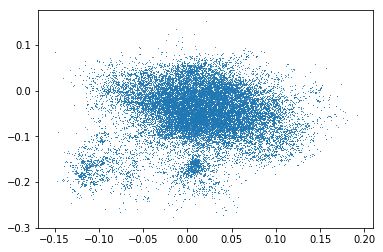

In [102]:
transposed_zmeans = np.array(z_means.cpu()).transpose()

plt.scatter(transposed_zmeans[0], transposed_zmeans[1], s = 1, linewidths = 0)
plt.show()

In [103]:
from sklearn.cluster import KMeans

z_means_np = np.array(z_means.cpu())
kmeans = KMeans(n_clusters=12, random_state=1).fit(z_means_np)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [104]:
sample_points=len(z_means_np)

latent_dim = 2
fig = plt.figure(figsize=(12,12))
counter=0
cmap=kmeans.labels_
for z1 in range(latent_dim):
    for z2 in range(z1+1,latent_dim):
        counter+=1
        fig.add_subplot(latent_dim,latent_dim,counter)
        plt.title(str(z1)+"_"+str(z2))
        plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c=cmap[::-1], s = 15, alpha=0.01,marker="o")
#         plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c="y" ,alpha=0.3,marker="o")
        plt.scatter(z_means_np[0][z1], z_means_np[0][z2],c="r" ,alpha=1,s=40,marker="s")
        plt.xlabel("Latent dim"+str(z1+1))
        plt.ylabel("Latent dim"+str(z2+1));
plt.savefig("Try2_originalDropout.png")


NameError: name 'kmeans' is not defined

<Figure size 864x864 with 0 Axes>

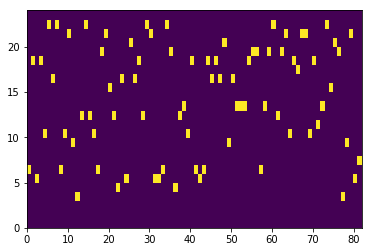

In [105]:
plt.pcolor(x_train[0].reshape(82, 24).transpose(1, 0))
plt.show()

In [106]:
if vae_type == 'full':
    m = torch.nn.Softmax()


    reshaped_fit_xtrain = m(fit_xtrain.reshape(45000 * 82, 24)).reshape(45000, 82, 24).transpose(2, 1)


  # reshaped_fit_xtrain = torch.stack(list(map(m, fit_xtrain))).reshape(50000, 82, 24).transpose(2, 1)
elif vae_type == 'conv':
    m = torch.nn.Softmax()


    reshaped_fit_xtrain = m(fit_xtrain.reshape(45000, 82, 24)).transpose(2, 1)


  # reshaped_fit_xtrain = torch.stack(list(map(m, fit_xtrain))).reshape(50000, 82, 24).transpose(2, 1)

elif vae_type == 'rec':
    m = torch.nn.Softmax()
    
    reshaped_fit_xtrain = m(fit_xtrain.reshape(45000,82,24).transpose(2,1))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


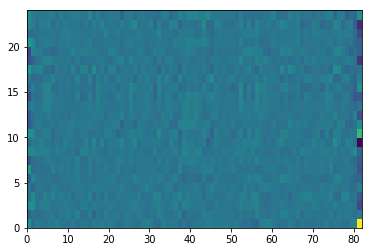

In [107]:
plt.pcolor(reshaped_fit_xtrain[0].cpu())

In [108]:
sample_size=batch_size*int(len(test_data_plus)/batch_size)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)
x_decoded=reshaped_fit_xtrain

digit = reshaped_fit_xtrain[0]#fit_xtrain_softmax_reshaped[0]
digit_wt = digit
digit_wt = normalize(digit.cpu(),axis=0, norm='l1')
# print (digit_wt)


wt_prob=compute_log_probability(test_data_plus[0].reshape(digit_size, sequence_size),digit_wt)
#print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size, sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = x_decoded[sample]
#     print (digit)
#     print (digit_avg)
#     digit_wt_i = normalize(digit,axis=0, norm='l1')
    digit_wt_i = digit
    
#     print (digit_wt_i)
    
    digit_avg+=np.array(digit_wt_i.cpu()) * 1. / sample_for_averging_size
    
    wt_p=compute_log_probability(test_data_plus[sample].reshape(digit_size, sequence_size),digit_wt_i.cpu())
    wt_probs.append(wt_p)
    counter+=1
    
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[] #first plug in just the sequences
fitnesses_vs_avg=[] 

for sample in range(1,sample_size):
    digit = x_decoded[sample]
#     digit = normalize(digit,axis=0, norm='l1')
    
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size, sequence_size),digit.cpu())-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size, sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size, sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
print ("Spearman",spearmanr(fitnesses_vs_avg,target_values_singles[:sample_size-1]))
print ("Pearson", pearsonr(fitnesses_vs_avg,target_values_singles[:sample_size-1]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses_vs_wt,target_values_singles[:sample_size-1]))
print ("Pearson", pearsonr(fitnesses_vs_wt,target_values_singles[:sample_size-1]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses,target_values_singles[:sample_size-1]))
print ("Pearson", pearsonr(fitnesses,target_values_singles[:sample_size-1])) 

Spearman SpearmanrResult(correlation=-0.003898952400759738, pvalue=0.8936120091084995)
Pearson (0.02768872903297902, 0.3421581862442896)
------------------------------
Spearman SpearmanrResult(correlation=0.05497584720845208, pvalue=0.059145950198686716)
Pearson (0.08388370189141227, 0.003947780859156703)
------------------------------
Spearman SpearmanrResult(correlation=0.0006085460243089096, pvalue=0.9833467891391192)
Pearson (0.012191676470954744, 0.6758068610037712)


In [109]:
perf = np.array([losses_train,accuracies_train,losses_test,accuracies_test,[0 for i in losses_test]])
perf = np.transpose(perf)

perf[-6,-1] = spearmanr(fitnesses_vs_avg,target_values_singles[:sample_size-1]).correlation
perf[-5,-1] = pearsonr(fitnesses_vs_avg,target_values_singles[:sample_size-1])[0]
perf[-4,-1] = spearmanr(fitnesses_vs_wt,target_values_singles[:sample_size-1]).correlation
perf[-3,-1] = pearsonr(fitnesses_vs_wt,target_values_singles[:sample_size-1])[0]
perf[-2,-1] = spearmanr(fitnesses,target_values_singles[:sample_size-1]).correlation
perf[-1,-1] = pearsonr(fitnesses,target_values_singles[:sample_size-1])[0]
    
np.save('results_{}.txt'.format(run_id),perf)

NameError: name 'run_id' is not defined

In [0]:
perf

array([[tensor(46209.6914, grad_fn=<AddBackward0>), 0.683179674796748,
        tensor(46217.6641, grad_fn=<AddBackward0>), 0.6841414634146341,
        0.4578265313051431],
       [tensor(50862.2422, grad_fn=<AddBackward0>), 0.7036788617886179,
        tensor(50878.2852, grad_fn=<AddBackward0>), 0.7027926829268293,
        0.5079178720488651],
       [tensor(59320.0781, grad_fn=<AddBackward0>), 0.7018785907859079,
        tensor(59321.6133, grad_fn=<AddBackward0>), 0.7032731707317074,
        0.4436030731647449],
       [tensor(54943.0195, grad_fn=<AddBackward0>), 0.7167444444444444,
        tensor(54955.0117, grad_fn=<AddBackward0>), 0.7172926829268292,
        0.48681000381760786],
       [tensor(57309.3906, grad_fn=<AddBackward0>), 0.7249265582655826,
        tensor(57324.5859, grad_fn=<AddBackward0>), 0.7245121951219512,
        0.02598174839699039],
       [tensor(55233.3086, grad_fn=<AddBackward0>), 0.7319241192411924,
        tensor(55250.3008, grad_fn=<AddBackward0>), 0.73216585

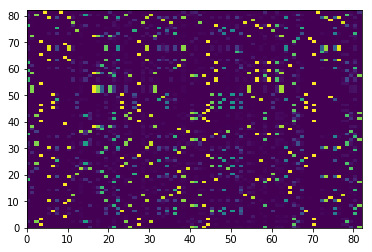

In [0]:
plt.pcolor(np.matmul(test_data_plus[0].reshape(digit_size, sequence_size).T, digit_wt))

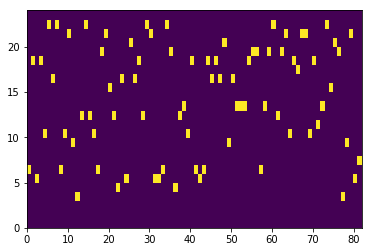

In [0]:
plt.pcolor(test_data_plus[0].reshape(digit_size, sequence_size))

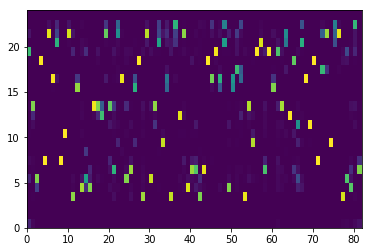

In [0]:
plt.pcolor(digit_wt)

In [0]:
spearmanr(fitnesses_vs_avg, fitnesses)

SpearmanrResult(correlation=-0.009824433997652364, pvalue=0.7361261981734875)

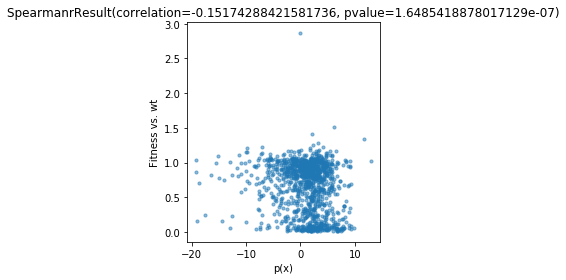

In [0]:
plt.scatter(fitnesses_vs_wt, target_values_singles[:sample_size-1], alpha = 0.5, s = 10)
plt.ylabel("Fitness vs. wt")
plt.xlabel("p(x)")
plt.title(spearmanr(fitnesses_vs_wt, target_values_singles[:sample_size-1]))
plt.tight_layout()
plt.savefig("Correlation.png")
plt.show()


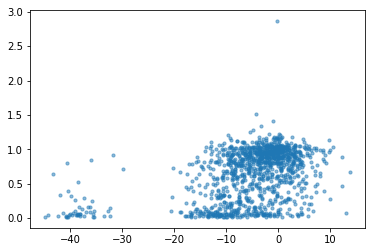

In [0]:
plt.scatter(fitnesses_vs_wt, target_values_singles[:sample_size-1], alpha = 0.5, s = 10)
plt.show()

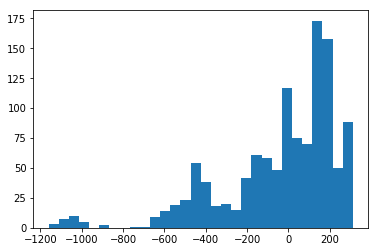

In [0]:
plt.hist(fitnesses,bins=30)
plt.show()

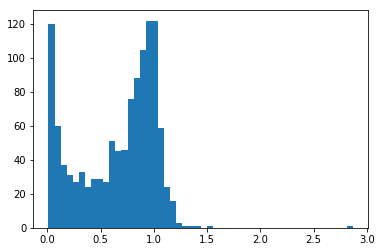

In [0]:
plt.hist(target_values_singles[:sample_size-1], bins=50)
plt.show()

We have kept track of some performance metrics, so we can follow whether the network was still improving. 

In [0]:
#print performance measures over time
keys=["categorical_accuracy","top_k_categorical_accuracy"]
for key in keys:
    if not key.startswith("val_"):
        plt.plot(hist.history["val_"+key],label="val_"+key)
plt.xlabel("epochs")
plt.legend(bbox_to_anchor=(1.6,0.5));

Our metric of interest of course is the prediction power (here spearman's rank correlation) between protein sequence probability and the actual fitness measurements.

In [0]:
plt.plot(spearman_measure.scores)
plt.title("Spearman corr over epochs")
plt.xlabel("epochs")
plt.ylabel("Spearman corr");

## 3. Exploring the Latent Space
It is helpful to visualize the latent space to see if the network is separating any mutants (and how the variance is captured). The wildtype sequence is highlighted in red. 

In [0]:
encoder = Model(x, z_mean)
sample_points=data_set_size

sample_size=batch_size*int(len(test_data_plus)/batch_size)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)

#wildtype in red
x_train_encoded = encoder.predict(training_data[:sample_points], batch_size=batch_size)
x_test_encoded=encoder.predict(all_test_data[:15060], batch_size=batch_size)
wt_encoding=x_train_encoded[0].reshape(1,latent_dim)

x_decoded=vae.predict(test_data_plus[0:sample_size],batch_size=batch_size)
digit = x_decoded[0].reshape(digit_size,sequence_size)
digit_wt = normalize(digit,axis=0, norm='l1')
wt_prob=compute_log_probability(test_data_plus[0].reshape(digit_size,sequence_size),digit_wt)

fig = plt.figure(figsize=(12,12))
counter=0
cmap=["r" if i==0 else "b" for i in range(sample_points)]
for z1 in range(latent_dim):
    for z2 in range(z1+1,latent_dim):
        counter+=1
        fig.add_subplot(latent_dim,latent_dim,counter)
        plt.title(str(z1)+"_"+str(z2))
        plt.scatter(x_train_encoded[:, z1][::-1], x_train_encoded[:, z2][::-1],c=cmap[::-1] ,alpha=0.01)

        plt.scatter(x_test_encoded[:, z1][::-1], x_test_encoded[:, z2][::-1],c="y" ,alpha=0.3)
        plt.scatter(x_train_encoded[0][z1], x_train_encoded[0][z2],c="r" ,alpha=1)
        plt.xlabel("Latent dim"+str(z1+1))
        plt.ylabel("Latent dim"+str(z2+1));

We can see that there is an interesting branching structure occuring. We can decipher this structure. It is also possible to run the network with more latent variables (usually improves the results by a little). In such cases we can also plot the latent dimensions 3 at a time (instead of 2 at a time above).

In [0]:
# for 3d Visualization of latent space if at least three dimensions existed
if latent_dim>2:
    %matplotlib inline
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    encoder = Model(x, z_mean)
    # display a 2D plot of the digit classes in the latent space
    #x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

    plt.figure(figsize=(8, 8))
    #plt.scatter(x_test_encoded[:, 0], x_test_encoded[: ,1])#, c=y_test)
    ax.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1],x_train_encoded[:, 2],c="b",alpha=0.01)
    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2],c="y",alpha=0.75)
    ax.scatter(x_train_encoded[0][0], x_train_encoded[0][1],x_train_encoded[0][2], c="r" ,alpha=1)


To further understand the structure we saw above we first look at the distribution of distances of sequences from each other. We can cluster the data using a simple approach like k-means, and then re-map that onto our plot above.

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12, random_state=1).fit(training_data[:data_set_size])

In [0]:
sample_points=data_set_size

fig = plt.figure(figsize=(12,12))
counter=0
cmap=kmeans.labels_
for z1 in range(latent_dim):
    for z2 in range(z1+1,latent_dim):
        counter+=1
        fig.add_subplot(latent_dim,latent_dim,counter)
        plt.title(str(z1)+"_"+str(z2))
        plt.scatter(x_train_encoded[:, z1][::-1], x_train_encoded[:, z2][::-1],c=cmap[::-1] ,alpha=0.01,marker="o")
        plt.scatter(x_test_encoded[:, z1][::-1], x_test_encoded[:, z2][::-1],c="y" ,alpha=0.3,marker="o")
        plt.scatter(x_test_encoded[0][z1], x_test_encoded[0][z2],c="r" ,alpha=1,s=40,marker="s")
        plt.xlabel("Latent dim"+str(z1+1))
        plt.ylabel("Latent dim"+str(z2+1));


It appears that the k-means clustering strongly aligns with how the network has split the training data into branches. Hence sequence distances are a large factor in this projection onto the latent space. 

Next, I compute the likelihood of the wildtype sequence occuring in each position within the latent space. This is interesting because it lets us visually how much the distribution of sequences is favorable to the wildtype at that particular place in the latent space. To see how this probability is computed, see [below](#P_compute).


In [0]:
probs=[]
points_x=np.arange(min(x_train_encoded[:, 0]),max(x_train_encoded[:, 0]),(max(x_train_encoded[:, 0])-min(x_train_encoded[:, 0]))*0.0025)
points_y=np.arange(min(x_train_encoded[:, 1]),max(x_train_encoded[:, 1]),(max(x_train_encoded[:, 1])-min(x_train_encoded[:, 1]))*0.0025)

decoder_input = Input(shape=(latent_dim,))
_x_decoded_mean= decoder_out(decoder_3(decoder_2d(decoder_2(decoder_1(decoder_input)))))

generator = Model(decoder_input, _x_decoded_mean)

for i in points_x:
    for j in points_y:
        x_decoded=generator.predict(np.array([i,j]).reshape(1,-1)).reshape(digit_size,sequence_size)
        digit_prob=normalize(x_decoded,axis=0, norm='l1')
        value_to_append=compute_log_probability(all_test_data[0].reshape(digit_size,sequence_size),digit_prob)
        probs.append(value_to_append)
       #if interested in seeing which points in the matrix come closest to the wildtype, they can be printed using the code that follows 
        #if i<wt_encoding[0][0]+0.1 and i>=wt_encoding[0][0]-0.1:
         #   if j<wt_encoding[0][1]+0.1 and j>=wt_encoding[0][1]-0.1:
          #      print (i,j,value_to_append)
            
            
probs=np.array(probs)
probs[probs<-2000]=-2000
probs=probs.reshape(len(points_x),len(points_y)).T

We can now plot the probabilities onto the latent space. White areas are where wildtype occurs with the same probability as it’s own coordinate in the latent space. Red means that wildtype is less favored in those locations, and blue means it is more favored (than it’s own location). Notice that in certain datasets (and realizations of the latent space), the positive range is very small and it may appear that there is a flat dark blue area. This is simply because the sequences that are better than wildtype are usually just slightly better, and hence there is little room for the positive side of the colorbar to show its gradient. The wildtype may also be in a blue area because of the "binning" or pixelation as a result of the way we compute the probabilities.  

In [0]:
import matplotlib.cm 
fig = plt.figure(figsize=(12,9))
orig_cmap = matplotlib.cm.bwr_r
midpoint=((np.min(probs)-wt_prob)/(np.min(probs)-np.max(probs)))
offset_top=np.max(probs)+5 #better visualization because often the "beneficial" coords are very close to wildtype in fitness, coarse graining may result in misleading visuals

shrunk_cmap = shiftedColorMap(orig_cmap, start=0.0, midpoint=midpoint, stop=1, name='shrunk')
plt.pcolormesh(points_x,points_y, probs,cmap=shrunk_cmap,vmin=np.min(probs), vmax=offset_top)
ax=plt.colorbar()
ax.set_label("log probability of wildtype")
plt.scatter(x_train_encoded[:, 0][::-1], x_train_encoded[:, 1][::-1],c=cmap[::-1] ,alpha=0.1)
plt.scatter(x_test_encoded[:, 0][1180:], x_test_encoded[:, 1][1180:],c="purple" ,alpha=0.3)
plt.scatter(x_test_encoded[:, 0][1:1180], x_test_encoded[:, 1][1:1180],c="g" ,alpha=0.3)
plt.scatter(x_train_encoded[0][0], x_train_encoded[0][1],c="r" ,alpha=1,s=40,marker="s")
plt.xlabel("latent dim 1")
plt.ylabel("latent dim 2")

plt.xlim(min(points_x),max(points_x))
plt.ylim(min(points_y),max(points_y));

We can zoom in closer to the wildtype, here we removed the cluster colors, and the yellow dots show the test data (single and double mutants). 

In [0]:
fig = plt.figure(figsize=(12,8))

plt.pcolor(points_x,points_y, probs,cmap=shrunk_cmap,vmax=offset_top)
ax=plt.colorbar()
ax.set_label("log probability of wildtype")

plt.scatter(x_train_encoded[:, 0][::-1], x_train_encoded[:, 1][::-1],c=cmap[::-1] ,alpha=0.5)
plt.scatter(x_test_encoded[:, 0][1180:], x_test_encoded[:, 1][1180:],c="purple" ,alpha=0.3,label="double_mut")
plt.scatter(x_test_encoded[:, 0][1:1180], x_test_encoded[:, 1][1:1180],c="g" ,alpha=0.3,label="single_mut")
plt.scatter(x_train_encoded[0][0], x_train_encoded[0][1],c="r" ,alpha=1,s=40,marker="s",label="wt")

wt_x=wt_encoding[0][0]
wt_y=wt_encoding[0][1]
offset=2
plt.xlim(wt_x-offset,wt_x+offset);
plt.ylim(wt_y-offset,wt_y+offset);

plt.legend();
plt.xlabel("latent dim 1")
plt.xlabel("latent dim 2");

We can see how the reconstruction changes as we walk from a wildtype to a mutant in latent space.

In [0]:
x_decoded=vae.predict(test_data_plus[0:200],batch_size=batch_size)
digit_wt = x_decoded[0].reshape(digit_size,sequence_size)
digit_wt = normalize(digit_wt,axis=0, norm='l1')

mut_sample=100

digit_p= x_decoded[mut_sample].reshape(digit_size,sequence_size)
digit_p = normalize(digit_p,axis=0, norm='l1')

fig = plt.figure(figsize=(12,18))

fig.add_subplot(412)

plt.pcolor(digit_wt,cmap="hot",vmin=0,vmax=1)
plt.colorbar()

plt.xlim(0,82);
plt.ylim(0,24);
plt.title("wild_type_reconstruction")
plt.yticks(range(24),ORDER_LIST)

fig.add_subplot(413)

plt.pcolor(digit_p,cmap="hot",vmin=0,vmax=1)
plt.colorbar()

plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)

plt.title("mutant_reconstruction")

fig.add_subplot(411)

plt.pcolor(abs(test_data_plus[0].reshape(digit_size,sequence_size)+(test_data_plus[mut_sample].reshape(digit_size,sequence_size))*2),cmap="hot",vmin=0,vmax=3)

plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)

plt.title("one hot encoding of input sequence (wt(red), mut(yellow))")

fig.add_subplot(414)

plt.pcolor(-digit_wt+digit_p,cmap="bwr",vmin=-0.05,vmax=0.05)
plt.colorbar()
plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)

plt.title("difference in distribution (mutant-wt): Notice that the scale is different");

Notice the slight change in the probabilities, for other positions in the sequence, not just those that differed in the original input sequence (fourth panel).  


Alternatively, we can move in the latent dimension (along the eigen basis) by preturbing coordinates starting at the wildtype and observe the change in probabilities. To do so, we first compute the principal eigenvector for the test data.

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_result=pca.fit(x_test_encoded)

print("Explained variance by first component", pca.explained_variance_ratio_) 

We can plot the points along the eigenvector in the latent space (shown in cyan).

In [0]:
fig = plt.figure(figsize=(10,10))
plt.pcolormesh(points_x,points_y, probs,cmap=shrunk_cmap,vmin=np.min(probs), vmax=offset_top)


plt.colorbar() 
plt.scatter(x_train_encoded[:,0][::-1], x_train_encoded[:, 1][::-1],c="b" ,alpha=0.05)
plt.scatter(x_test_encoded[:, 0][::-1], x_test_encoded[:, 1][::-1],c="y" ,alpha=0.3)


start_l=-5
end_l=5
line_start=pca.inverse_transform(np.array([start_l]).reshape(1,-1))
line_end=pca.inverse_transform(np.array([end_l]).reshape(1,-1))

for i in np.arange(start_l,end_l,0.25):
    
    perturb=pca.inverse_transform(np.array([i]).reshape(1,-1))
    perturbed=perturb
    plt.scatter(perturbed[0][0],perturbed[0][1],c="c",alpha=1,s=40)

plt.plot([line_start[0][0],line_end[0][0]],[line_start[0][1],line_end[0][1]],c="c")

plt.scatter(wt_encoding[0][0],wt_encoding[0][1],c="red",s=40)

offset=8
plt.xlim(wt_x-offset,wt_x+offset);
plt.ylim(wt_y-offset,wt_y+offset);

If we move along that axis by a tiny amount and reconstruct the sequence, we will see what is being updated.

In [0]:
perturb=pca.inverse_transform(np.array([0.01]).reshape(1,-1))

x_decoded=generator.predict(perturb)

digit_p = x_decoded.reshape(digit_size,sequence_size)
digit_p = normalize(digit_p,axis=0, norm='l1')
fig = plt.figure(figsize=(12,15))

fig.add_subplot(311)
plt.title("wild_type_reconstruction")

plt.pcolor(digit_wt,cmap="hot")
plt.colorbar()
plt.xlim(0,82);
plt.ylim(0,24);
plt.ylabel("AA")
plt.yticks(range(24),ORDER_LIST)



fig.add_subplot(312)
plt.title("mutant_reconstruction")
plt.pcolor(digit_p,cmap="hot")
plt.colorbar()
plt.xlim(0,82);
plt.ylim(0,24);
plt.ylabel("AA")
plt.yticks(range(24),ORDER_LIST)

fig.add_subplot(313)

plt.pcolor(-digit_wt+digit_p,cmap="bwr",vmin=-0.05,vmax=0.05)
plt.colorbar()
plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)

plt.title("difference in distribution (mutant-wt): Notice that the scale is different");

If you want to see how the walk along the axis changes the sequence, you can use the code below to generate a set of images (like the gif on the blog). 

In [0]:
count=0

start_l=-15
end_l=15
line_start=pca.inverse_transform(np.array([start_l]).reshape(1,-1))
line_end=pca.inverse_transform(np.array([end_l]).reshape(1,-1))


for i in np.arange(start_l,end_l,1):
    perturb=pca.inverse_transform(np.array([i]).reshape(1,-1))

    x_decoded=generator.predict(perturb)

    digit_p = x_decoded.reshape(digit_size,sequence_size)
    digit_p = normalize(digit_p,axis=0, norm='l1')
    most_likely=most_likely_seq(digit_p)
    fig = plt.figure(figsize=(20,8))
    fig.add_subplot(121)
    plt.xlabel("wt preturbed by "+str(i))
    plt.title(most_likely)
    plt.pcolor(digit_p,cmap="hot");
    plt.xlim(0,82);
    plt.ylim(0,24);
    plt.ylabel("AA")
    plt.yticks(range(24),ORDER_LIST)
    plt.xticks(range(82),list(most_likely))
    fig.add_subplot(122)
    plt.pcolormesh(points_x,points_y, probs,cmap=shrunk_cmap,vmin=np.min(probs), vmax=offset_top)
    plt.colorbar() 
    
    perturbed=perturb

    plt.scatter(x_train_encoded[:,0][::-1], x_train_encoded[:, 1][::-1],c="b" ,alpha=0.05)
    plt.scatter(x_test_encoded[:, 0][::-1], x_test_encoded[:, 1][::-1],c="g" ,alpha=0.25,s=25)
    plt.plot([line_start[0][0],line_end[0][0]],[line_start[0][1],line_end[0][1]],"--",c="c",linewidth=2,alpha=0.4)

    plt.scatter(wt_encoding[0][0],wt_encoding[0][1],c="r",s=40)
    plt.scatter(perturbed[0][0],perturbed[0][1],c="c",s=60,alpha=1)



    offset=15
    plt.xlim(wt_x-offset,wt_x+offset);
    plt.ylim(wt_y-offset,wt_y+offset);
    plt.savefig("exploration/"+str(count)+".png");
    count+=1

Another approach to study the effects of particular mutations in the latent space is to actually annotate the location that each mutation occupies (on average) within the latent space. Below, I have mutated the same "G" amino acid into all of its variants in 3 different positions on the sequence (27,40,44, on the aligned columns). Then I plot the location of those mutations.

In [0]:
g_indices=[27,40, 44]#g
#k_indices=[33,41, 43] #k
#s_indices=[31,32,42] #s
single_mutants_g=[]
ref_seq=data.iloc[0]["seq"]
for ind in g_indices:
    for aa in ORDER_LIST:
        new_sequence=ref_seq[:ind]+aa+ref_seq[ind+1:]
        single_mutants_g.append(new_sequence)
        
one_hot_single_mutants_g=[]  

for mutant in single_mutants_g:
    one_hot_single_mutants_g.append(translate_string_to_one_hot(mutant,ORDER_LIST))

single_mutants_g_OH=np.array([np.array(list(sample.flatten())).T for sample in one_hot_single_mutants_g])
single_mutants_g_padded=np.vstack([single_mutants_g_OH,single_mutants_g_OH[:8]]) #padding so I can feed all of it to 

In [0]:
mutant_g_encoded = encoder.predict(single_mutants_g_padded, batch_size=batch_size)
mutant_g_encoded=mutant_g_encoded[:72]
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(x_train_encoded[0][0], x_train_encoded[0][1],c="r" ,alpha=1,s=40,marker="s",label="wt")
ax.scatter(mutant_g_encoded[:,0][:24], mutant_g_encoded[:, 1][:24],c="b" ,alpha=0,label="pos 27")

for i, txt in enumerate(ORDER_LIST):
    ax.annotate(txt, (mutant_g_encoded[:,0][i],mutant_g_encoded[:,1][i]),color="b",size="large")
    
ax.scatter(mutant_g_encoded[:,0][24:48], mutant_g_encoded[:, 1][24:48],c="g" ,alpha=0,label="pos 40")

for i, txt in enumerate(ORDER_LIST):
    ax.annotate(txt, (mutant_g_encoded[:,0][i+24],mutant_g_encoded[:,1][i+24]),color="g",size="large")
    
ax.scatter(mutant_g_encoded[:,0][48:], mutant_g_encoded[:, 1][48:],c="g" ,alpha=0,label="pos 44")

for i, txt in enumerate(ORDER_LIST):
    ax.annotate(txt, (mutant_g_encoded[:,0][i+48],mutant_g_encoded[:,1][i+48]),color="r",size="large")
    
plt.title("position 27 blue, postition 40 green, position 44 red, wt red square")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2");
offset=0.5
plt.xlim(wt_x-offset,wt_x+offset);
plt.ylim(wt_y-offset,wt_y+offset);

While there is some clustering of amino acids based on similarity and position, this trend is not consistent depending on the amino-acid/mutation and position of choice. We can also project the measured fitness onto the latent space. 

In [0]:
fig = plt.figure(figsize=(12,8))
import matplotlib.cm as cm
from matplotlib import colors

norm = colors.Normalize(vmin=min(target_values_doubles), vmax=1)
cmap_v = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap_v)

plt.scatter(x_test_encoded[:, 0][1180:], x_test_encoded[:, 1][1180:],c=list(map(m.to_rgba,target_values_doubles[:len(x_test_encoded[:, 1][1180:])])) ,alpha=0.3,label="double_mut")
plt.scatter(x_test_encoded[:, 0][1:1180], x_test_encoded[:, 1][1:1180],c=list(map(m.to_rgba,target_values_singles[1:1180])) ,alpha=0.3,label="single_mut")
plt.scatter(x_train_encoded[0][0], x_train_encoded[0][1],c="w" ,alpha=1,s=40,marker="s",label="wt")

wt_x=wt_encoding[0][0]
wt_y=wt_encoding[0][1]
offset=2
plt.xlim(wt_x-offset,wt_x+offset);
plt.ylim(wt_y-offset,wt_y+offset);

plt.legend();
plt.xlabel("latent dim 1")
plt.ylabel("latent dim 2");

There are no obvious trends in the latent space that would correspond to fitness values. 

<a id='P_compute'></a>


## 4. Predicting fitness based on sequence probability

We compute the (log) probability of a sequence as:
$$ \log(trace(H^T P)) $$

Where $H$ is the one-hot encoding of the sequence of interest, and $P$ is the probability weight matrix generated by feeding the network a sequence. Taking the trace of the matrix product is similar to the dot product of two vectors. We compute the fitness in three highly correlated ways (although depending on the dataset, these correlations change). The difference in these approaches is in how to compute $P$. 

(1)$P$ is the reconstruction of the same sequence that $H$ represents. (we call this prediction or "fitness" in the code)

(2) $P$ is the reconstruction of the wildtype sequence.  (we call this prediction_wt or "fitness_wt" in the code)

(3) $P$ is an average reconstruction of 100 samples of mutants. (we call this prediction_avg or "fitness_avg" in the code)

### 4.1. Single mutants

We can now use the trained network to predict the fitnesses. The first step is to compute the fitnesses for all single mutant sequences (and compare it to the wildtype). 

In [0]:
sample_size=batch_size*int(len(test_data_plus)/batch_size)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)
x_decoded=vae.predict(test_data_plus[0:sample_size],batch_size=batch_size)

digit = x_decoded[0].reshape(digit_size,sequence_size)
digit_wt = normalize(digit,axis=0, norm='l1')
wt_prob=compute_log_probability(test_data_plus[0].reshape(digit_size,sequence_size),digit_wt)
#print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size,sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = x_decoded[sample].reshape(digit_size,sequence_size)
    digit_wt_i = normalize(digit,axis=0, norm='l1')
    
    digit_avg+=digit_wt_i*1./sample_for_averging_size
    wt_p=compute_log_probability(test_data_plus[sample].reshape(digit_size,sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[]
fitnesses_vs_avg=[]

for sample in range(1,sample_size):
    digit = x_decoded[sample].reshape(digit_size,sequence_size)
    digit = normalize(digit,axis=0, norm='l1')
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size,sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size,sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(test_data_plus[sample].reshape(digit_size,sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
print ("Spearman",spearmanr(fitnesses,target_values_singles[:sample_size-1]))
print ("Pearson", pearsonr(fitnesses,target_values_singles[:sample_size-1]))

As a first step, we draw the distribution of the normalized predicted fitnesses vs. the experimental data. We care about the relative distributions, rather than the exact values, so we can renormalize the predictions to roughly fall in the range of the data.

In [0]:
predictions=np.array(list(map(lambda x: x*1./(4*(max (fitnesses))),fitnesses))) #arbitrary renormalization
indip=list(map(lambda x: x*1./max (exp_data_singles["effect_prediction_independent"]),exp_data_singles["effect_prediction_independent"]))
epis=list(map(lambda x: x*1./max (exp_data_singles["effect_prediction_epistatic"]),exp_data_singles["effect_prediction_epistatic"]))

In [0]:
plt.hist(predictions[predictions > -1E10],alpha=0.7,label="predicted fitness"); #filter out -inf
plt.hist(np.array(target_values_singles)-1,alpha=0.5,label="experimental fitness");
plt.xlabel("relative fitness");
plt.ylabel("count")
plt.legend();

In [0]:
len(predictions),len(target_values_singles)

Note that the mismatch in lenght is due to batch size partitioning of the data (this can be fixed, but doesn't change much about the results). We can also explicitly look at how these values change together along all possible mutations. To visualize the predictions vs the real data, we use a [smoothing function](http://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay) to be able to visually relate the fitness ascribed to many variants, with those that the network predicted.  

In [0]:
fig, ax = plt.subplots(num=None, figsize=(18,4), dpi=90)
window=9
poly=3
plt.step(range(len(target_values_singles)),savitzky_golay(list(target_values_singles),window,poly),label="experiment")
plt.step(range(len(predictions)),savitzky_golay(predictions,window,poly),linewidth=2,alpha=0.6,label="predictions")
plt.legend();
plt.xlabel("mutations")
plt.ylabel("fitness");

To remove the information that is purely due to column entropy, we subtract it from our prediction values and compare it to the epistatic predictions from Hopf paper. 

In [0]:
fig, ax = plt.subplots(num=None, figsize=(18,4), dpi=90)
plt.step(range(len(predictions)),savitzky_golay(([a-b for a,b in zip(predictions,indip)]),window,poly))
plt.step(range(len(epis)),savitzky_golay(([a-b for a,b in zip(epis,indip)]),window,poly))
plt.xlabel("mutations")
plt.ylabel("fitness");

Finally, we can plot the predictions across the entire mutation landscape and compare it with the two other prediction methods (column entropy and second-order epistasis). 

In [0]:
len_seq=batch_size*int(len(test_data_plus)/batch_size)
compare_on=False


fig, ax = plt.subplots(num=4, figsize=(18,8), dpi=90)#, facecolor='w', edgecolor='k'),
plt.subplot(311)
plt.xlim(0,len_seq*1./3)
plt.step(range(int(len_seq*1./3)),savitzky_golay(list(target_values_singles[:int(len_seq*1./3)]),window,poly),label="experimental $\Delta f$ measurement")
plt.step(range(int(len_seq*1./3)),savitzky_golay(predictions[:int(len_seq*1./3)],window,poly), label="predicted $\Delta f$")
if compare_on: 
    plt.plot(range(int(len_seq*1./3)),savitzky_golay(indip[:int(len_seq*1./3)],window,poly))
    plt.plot(range(int(len_seq*1./3)),savitzky_golay(epis[:int(len_seq*1./3)],window,poly))


plt.legend(bbox_to_anchor=(0.58,1.05))
plt.ylabel("$\Delta$ fitness")

plt.subplot(312)
plt.xlim(len_seq*1./3,len_seq*2./3)
plt.step(range(int(len_seq*1./3),int(len_seq*2./3)),savitzky_golay(list(target_values_singles[int(len_seq*1./3):int(len_seq*2./3)]),window,poly))
plt.step(range(int(len_seq*1./3),int(len_seq*2./3)),savitzky_golay(predictions[int(len_seq*1./3):int(len_seq*2./3)],window,poly),linewidth=2)
plt.ylabel("$\Delta$ fitness")
if compare_on: 
    plt.plot(range(int(len_seq*1./3),int(len_seq*2./3)),savitzky_golay(indip[int(len_seq*1./3):int(len_seq*2./3)],window,poly))
    plt.plot(range(int(len_seq*1./3),int(len_seq*2./3)),savitzky_golay(epis[int(len_seq*1./3):int(len_seq*2./3)],window,poly))

plt.subplot(313)
plt.xlim(len_seq*2./3,len_seq)
plt.step(range(int(len_seq*2./3),len_seq),savitzky_golay(list(target_values_singles[int(len_seq*2./3):len_seq]),window,poly))
plt.step(range(int(len_seq*2./3),len_seq-1),savitzky_golay(predictions[int(len_seq*2./3):len_seq],window,poly),linewidth=2)

if compare_on: 
    plt.plot(range(int(len_seq*2./3),len_seq),savitzky_golay(indip[int(len_seq*2./3):len_seq],window,poly))
    plt.plot(range(int(len_seq*2./3),len_seq),savitzky_golay(epis[int(len_seq*2./3):len_seq],window,poly))

plt.ylabel("$\Delta$ fitness")
plt.xlabel("Position");

We can also visualize the prediction vs. fitness data differently. The red line represents perfect correlation, the blue distribution is the actual comparison. 

In [0]:
from sklearn.metrics.cluster import normalized_mutual_info_score
fig = plt.figure(figsize=(8,5))

x1=predictions

y1=target_values_singles[:len(predictions)]

plt.scatter(x1,y1,alpha=0.2)
plt.plot(sorted(x1),sorted(y1),"r",linewidth=4,alpha=0.9)
plt.title(str(spearmanr(x1,y1)))
plt.xlabel("prediction")
plt.ylabel("experiment")
print("Mutual info:", normalized_mutual_info_score(x1,y1))

He is a summary of the results in a table. 

In [0]:
size=len(predictions)
fitness_data=pd.DataFrame(columns=["lin","log","pred_wt","pred","pred_avg"])

fitness_data["experimental"]=exp_data_singles["linear"][:size]
fitness_data["effect_prediction_epistatic"]=exp_data_singles["effect_prediction_epistatic"][:size]
fitness_data["effect_prediction_independent"]=exp_data_singles['effect_prediction_independent'][:size]

fitness_data["prediction"]=fitnesses
fitness_data["prediction_wt"]=fitnesses_vs_wt
fitness_data["prediction_avg"]=fitnesses_vs_avg

corr_pred_singles=fitness_data.corr(method="spearman")
print("spearman rho correlations")
corr_pred_singles[["experimental"]]

### 4.2. Double mutants
We repeat the same analysis for double mutants. 

In [0]:
x_decoded=vae.predict(test_data_doubles_plus[0:sample_size],batch_size=batch_size)
digit_wt = x_decoded[0].reshape(digit_size,sequence_size)
digit_wt = normalize(digit_wt,axis=0, norm='l1')

mut_sample=100

digit_p= x_decoded[mut_sample].reshape(digit_size,sequence_size)
digit_p = normalize(digit_p,axis=0, norm='l1')

In [0]:
fig = plt.figure(figsize=(12,18))

fig.add_subplot(412)

plt.pcolor(digit_wt,cmap="hot",vmin=0,vmax=1)
plt.colorbar()

plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)
plt.title("wild_type_reconstruction")

fig.add_subplot(413)

plt.pcolor(digit_p,cmap="hot",vmin=0,vmax=1)
plt.colorbar()

plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)
plt.title("mutant_reconstruction")

fig.add_subplot(411)

plt.pcolor(abs(test_data_doubles_plus[0].reshape(digit_size,sequence_size)+(test_data_doubles_plus[mut_sample].reshape(digit_size,sequence_size))*2),cmap="hot",vmin=0,vmax=3)
plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)

plt.title("One hot encoding of sequences (wt(red), mut(yellow))")

fig.add_subplot(414)

plt.pcolor(-digit_wt+digit_p,cmap="bwr",vmin=-0.05,vmax=0.05)
plt.colorbar()
plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)

plt.title("difference in distribution (mutant-wt): Notice that the scale is different");

In [0]:
sample_size=batch_size*int(len(test_data_doubles_plus)/batch_size)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)
x_decoded=vae.predict(test_data_doubles_plus[0:sample_size],batch_size=batch_size)

digit = x_decoded[0].reshape(digit_size,sequence_size)
digit_wt = normalize(digit,axis=0, norm='l1')
wt_prob=compute_log_probability(test_data_doubles_plus[0].reshape(digit_size,sequence_size),digit_wt)
print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size,sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = x_decoded[sample].reshape(digit_size,sequence_size)
    digit_wt_i = normalize(digit,axis=0, norm='l1')
    
    digit_avg+=digit_wt_i*1./sample_for_averging_size
    wt_p=compute_log_probability(test_data_doubles_plus[sample].reshape(digit_size,sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[]
fitnesses_vs_avg=[]

for sample in range(1,sample_size):
    digit = x_decoded[sample].reshape(digit_size,sequence_size)
    digit = normalize(digit,axis=0, norm='l1')
    fitness=compute_log_probability(test_data_doubles_plus[sample].reshape(digit_size,sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(test_data_doubles_plus[sample].reshape(digit_size,sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(test_data_doubles_plus[sample].reshape(digit_size,sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)

In [0]:
predictions=np.array(list(map(lambda x: x*1./(4*max (fitnesses)),fitnesses))) #arbitrary renormalization
indip=list(map(lambda x: x*1./max (exp_data_singles["effect_prediction_independent"]),exp_data_singles["effect_prediction_independent"]))
epis=list(map(lambda x: x*1./max (exp_data_singles["effect_prediction_epistatic"]),exp_data_singles["effect_prediction_epistatic"]))
plt.hist(predictions[predictions > -1E10],alpha=0.7,label="predicted fitness"); #filter out -inf
plt.hist(np.array(target_values_doubles)-1,alpha=0.5,label="experimental fitness");
plt.xlabel("relative fitness");
plt.ylabel("count")
plt.legend();

In [0]:
fig = plt.figure(figsize=(8,5))

x1=predictions
y1=target_values_doubles[:len(predictions)]

plt.scatter(x1,y1,alpha=0.1)
plt.plot(sorted(x1),sorted(y1),"r",linewidth=4,alpha=0.9)
plt.title(str(spearmanr(x1,y1)))
plt.xlabel("prediction")
plt.ylabel("experiment")
print("Mutual info:", normalized_mutual_info_score(x1,y1))

In [0]:
size=len(predictions)
fitness_data=pd.DataFrame(columns=["lin","log","pred_wt","pred","pred_avg"])

fitness_data["experimental"]=exp_data_doubles["XY_Enrichment_score"][:size]
fitness_data["effect_prediction_epistatic"]=exp_data_doubles["effect_prediction_epistatic"][:size]
fitness_data["effect_prediction_independent"]=exp_data_doubles['effect_prediction_independent'][:size]

fitness_data["prediction"]=fitnesses
fitness_data["prediction_wt"]=fitnesses_vs_wt
fitness_data["prediction_avg"]=fitnesses_vs_avg

corr_pred_doubles=fitness_data.corr(method="spearman")
corr_pred_doubles[["experimental"]]

## Other datasets

We chose this dataset for demonstration because there was the possiblitiy of testing the model on both the single and double mutants. This also happens to be the dataset that our model performs best compared to the epistatic model. We summarize the results from some other datasets in compiled by the Hopf et al. paper below.  

**Important remark**: Note in the original version of this experiment we also ran this network on one viral dataset. However the size of the viral DNA (535), and diversity presented (requiring different re-weighting), relative to the size of this network made the training difficult to run to convergence. Hence we could not present the performance with the same confidence as the other datasets we tested our model on. Notably, in the viral case, the network did not perform better than the independent model. 

In [0]:
import seaborn as sns

In [0]:
meta_data=pd.DataFrame.from_csv("other_datasets.csv")

In [0]:
meta_data.head()

In [0]:
meta_data["ratio"]=meta_data["training_data_size(used)"]*1./meta_data["alignment_length"]
meta_data["diff_eps"]=meta_data["prediction_avg"]/meta_data["effect_prediction_epistasis"]
meta_data["diff_ind"]=meta_data["prediction_avg"]/meta_data["effect_prediction_independent"]

In [0]:
meta_data=meta_data.sort_values(by=["prediction_avg"])
meta_data=meta_data.reset_index()
del meta_data["index"]
meta_data

In [0]:
sns.jointplot(x="training_data_size(used)",y="diff_eps",data=meta_data,kind="reg")

In [0]:
#fig = plt.figure()
fig, ax = plt.subplots(figsize=(8,5))

plt.plot(meta_data["prediction_avg"],"rx-",label="prediction",linewidth=2)
#plt.plot(meta_data["prediction"],"r-",label="prediction")
#plt.plot(meta_data["prediction_wt"],"r--",label="prediction_wt")
plt.plot(meta_data["effect_prediction_epistasis"],"bx--",label="epistatic model Hopf et al.",linewidth=2)
plt.plot(meta_data["effect_prediction_independent"],"bx:",label="Independent model",linewidth=2)
ax.set_xticks(range(len(meta_data)))
ax.set_xticklabels(meta_data.dataset,rotation=45)
plt.xlabel("dataset")
plt.ylabel("Spearman rho")
plt.legend(bbox_to_anchor=(1.5,.75));